In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scratch.algos.rays import compute_cdf
import numpy as np

plt.rcParams.update({
    'font.family': 'serif'
})

FONTSIZE=14
SMALLER_FONTSIZE=12

In [44]:
def compute_alpha(func, x, d):
    a = 1. - torch.exp(-func(x) * d)
    return a

raw_features = torch.linspace(-20, 20, 10001)
pretty_d = {
    1e3: "1e3",
    1e2: "1e2",
    1e1: "1e1",
    1e0: "1e0",
    1e-1: "1e-1",
    1e-2: "1e-2",
    1e-3: "1e-3",
}

The following code block applies the $\mathtt{exp}$ activation function onto the raw feature vectors.

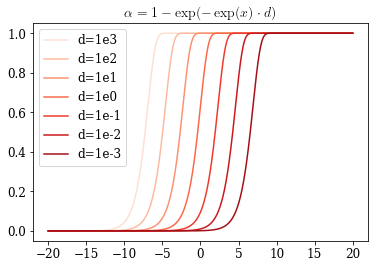

In [51]:
fig, ax = plt.subplots()
shades = sns.color_palette("Reds", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(torch.exp, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\exp(x) \cdot d)$", fontsize=FONTSIZE, usetex=True)
ax.legend(fontsize=SMALLER_FONTSIZE)
ax.tick_params(labelsize=SMALLER_FONTSIZE)
plt.savefig('exp.pdf', bbox_inches='tight', dpi=300)
plt.show()

The following code block applies the $\mathtt{softplus}$ activation function onto the raw feature vectors.

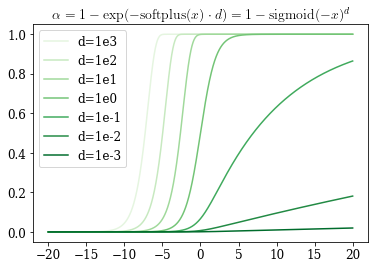

In [52]:
fig, ax = plt.subplots()
shades = sns.color_palette("Greens", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(F.softplus, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\mathrm{softplus}(x) \cdot d) = 1 - \mathrm{sigmoid}(-x)^d$", fontsize=FONTSIZE, usetex=True)
ax.legend(fontsize=SMALLER_FONTSIZE)
ax.tick_params(labelsize=SMALLER_FONTSIZE)
plt.savefig('softplus.pdf', bbox_inches='tight', dpi=300)
plt.show()

The following code block applies the $\mathtt{relu}$ activation function onto the raw feature vectors.

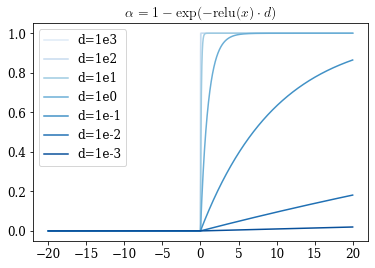

In [53]:
fig, ax = plt.subplots()
shades = sns.color_palette("Blues", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(torch.relu, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\mathrm{relu}(x) \cdot d)$", fontsize=FONTSIZE, usetex=True)
ax.legend(fontsize=SMALLER_FONTSIZE)
ax.tick_params(labelsize=SMALLER_FONTSIZE)
plt.savefig('relu.pdf', bbox_inches='tight', dpi=300)
plt.show()

CDF Plot of Nerf-Pytorch on Lego

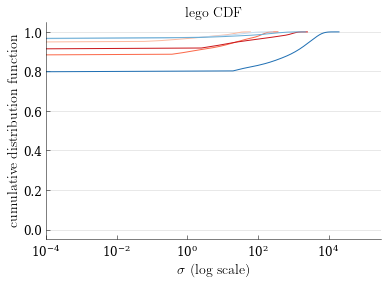

In [71]:
fig, ax = plt.subplots()
blue_shades = sns.color_palette("Reds", 3)
green_shades = sns.color_palette("Blues", 3)
bins_count = 1000

sns.despine()
ax.set_xscale('log')
ax.set_xlabel(r"$\sigma$ (log scale)", fontsize=FONTSIZE, usetex=True)
ax.set_ylabel("cumulative distribution function", fontsize=FONTSIZE, usetex=True)
ax.set_title(f"lego CDF", fontsize=FONTSIZE, usetex=True)

mapping = {
    0: 0.1,
    1: 1.0,
    2: 10.0
}

for mlp in ['coarse', 'fine']:
    colors = blue_shades if mlp == 'coarse' else green_shades
    for i in reversed(range(3)):
        sigmas = torch.load(f"{mapping[i]}_{mlp}.pt")
        cdf, bins = compute_cdf(sigmas, bins_count)
        cdf = torch.cat([torch.tensor([0.0]), cdf])
        ax.plot(bins, cdf, linewidth=1.0, color=colors[2-i])

bottom, top = ax.get_ylim()
ax.set_ylim([bottom, top])
ax.set_xlim([1e-4, 3e5])
ax.minorticks_off()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=SMALLER_FONTSIZE)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

fig.savefig(f"lego_cdf.pdf", dpi=300, bbox_inches='tight')
plt.show()

5-Pane 50th-percentile $\sigma$ Visualization from Nerfacto on Garden and Bicycle with both colorbar schemes

In [4]:
from matplotlib.colors import AsinhNorm, LogNorm, Normalize
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogFormatter
import imageio.v3 as imageio

def process_sigmas(sigmas, lower=1e-4, upper=1e4):
    sigmas[sigmas < lower] = lower
    sigmas[sigmas > upper] = upper
    return sigmas

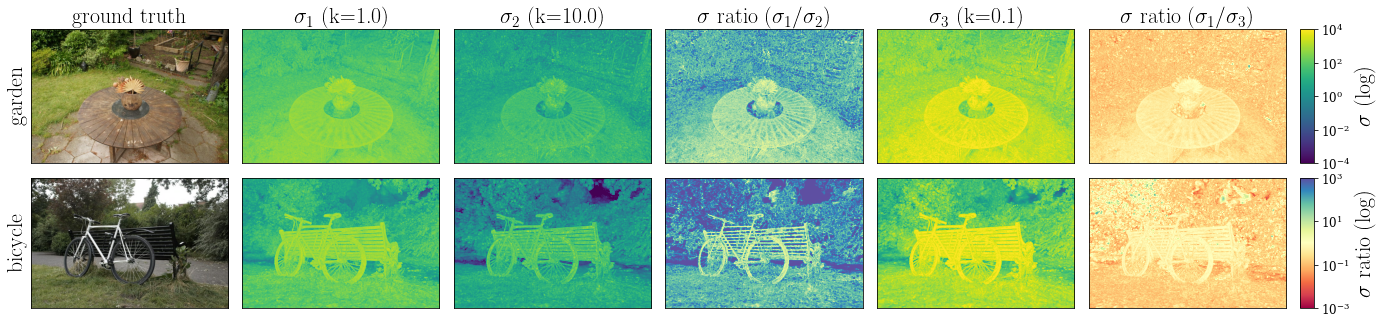

In [61]:
lower, upper = 1e-4, 1e4
ratio_lower, ratio_upper = 1e-3, 1e3
FONTSIZE=22

fig = plt.figure(figsize=(23, 8))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 6), axes_pad=0.2,
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.2,
)

# extract garden data
garden_gt = imageio.imread('garden_gt.JPG')
k_01 = process_sigmas(np.load("garden_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("garden_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("garden_10.npy").squeeze(), lower, upper)
height, width = k_01.shape

grid[0].imshow(garden_gt)
grid[0].set_title("ground truth", fontsize=FONTSIZE, usetex=True)
cb_base = grid[1].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(r"$\sigma_1$ (k=1.0)", fontsize=FONTSIZE, usetex=True)
grid[2].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[2].set_title(r"$\sigma_2$ (k=10.0)", fontsize=FONTSIZE, usetex=True)
grid[4].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[4].set_title(r"$\sigma_3$ (k=0.1)", fontsize=FONTSIZE, usetex=True)

high_ratio = process_sigmas(process_sigmas(np.load("garden_1.npy").squeeze(), ratio_lower, 1e2) / process_sigmas(np.load("garden_10.npy").squeeze(), ratio_lower, 1e2), ratio_lower, 1e2)
low_ratio = process_sigmas(process_sigmas(np.load("garden_1.npy").squeeze(), ratio_lower, ratio_upper) / process_sigmas(np.load("garden_01.npy").squeeze(), ratio_lower, ratio_upper), ratio_lower, 1e2)
grid[3].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, 1e2))
grid[3].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=FONTSIZE, usetex=True)
cb_ratio = grid[5].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[5].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=FONTSIZE, usetex=True)

# extract bicycle data
bicycle_gt = imageio.imread('bicycle_gt.JPG')
k_01 = process_sigmas(np.load("bicycle_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("bicycle_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("bicycle_10.npy").squeeze(), lower, upper)
height, width = k_01.shape

grid[6].imshow(bicycle_gt)
grid[7].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[8].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[10].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))

high_ratio = process_sigmas(process_sigmas(np.load("bicycle_1.npy").squeeze(), ratio_lower, 1e2) / process_sigmas(np.load("bicycle_10.npy").squeeze(), ratio_lower, 1e2), ratio_lower, 1e2)
low_ratio = process_sigmas(process_sigmas(np.load("bicycle_1.npy").squeeze(), ratio_lower, ratio_upper) / process_sigmas(np.load("bicycle_01.npy").squeeze(), ratio_lower, ratio_upper), ratio_lower, 1e2)
grid[9].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, 1e2))
grid[11].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))

for index in range(12):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 6]:
        grid[index].get_yaxis().set_visible(False)

# colorbars and labels
sigma = plt.colorbar(cb_base, cax=grid.cbar_axes[0])
sigma.set_label(r"$\sigma$ (log)", fontsize=FONTSIZE, usetex=True)
sigma.ax.tick_params(labelsize=SMALLER_FONTSIZE)

sigma_r = plt.colorbar(cb_ratio, cax=grid.cbar_axes[1])
sigma_r.set_label(r"$\sigma$ ratio (log)", fontsize=FONTSIZE, usetex=True)
sigma_r.ax.tick_params(labelsize=SMALLER_FONTSIZE)

grid[0].set_ylabel("garden", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[6].set_ylabel("bicycle", fontsize=FONTSIZE, usetex=True)
grid[6].set_yticks([])

plt.savefig(f"360_combo.pdf", dpi=300, bbox_inches='tight')
plt.show()

FONTSIZE=14

TensoRF 5-pane 50th-percentile visualizations on ship and lego

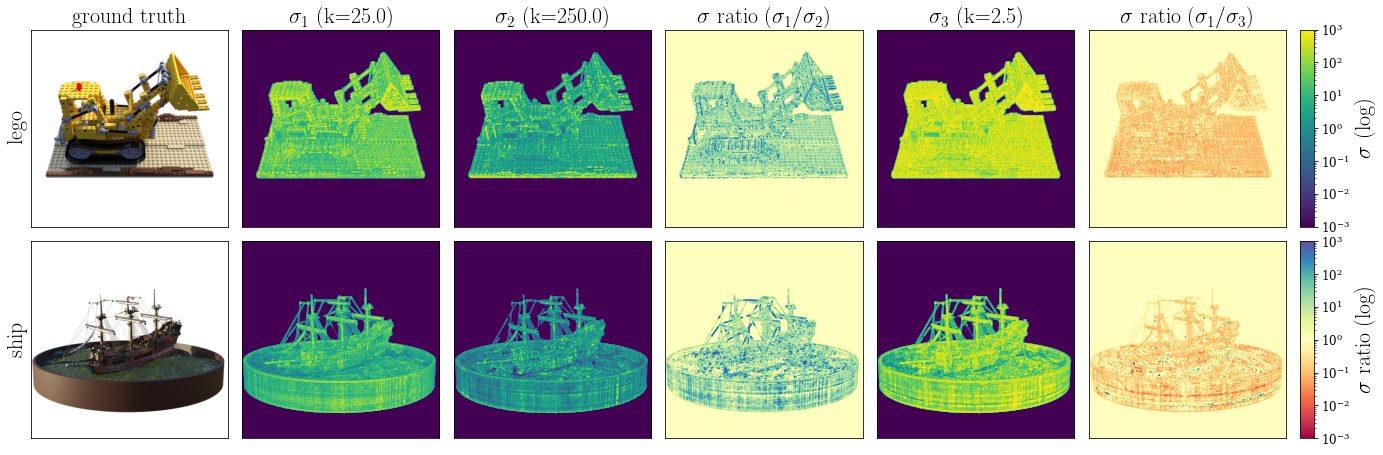

In [65]:
lower, upper = 1e-3, 1e3
ratio_lower, ratio_upper = 1e-3, 1e3
FONTSIZE=22

fig = plt.figure(figsize=(23, 8))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 6), axes_pad=0.2,
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.2,
)

# extract lego data
lego_gt = imageio.imread('lego_gt.png')
k_01 = process_sigmas(np.load("lego_k2_5.npy").squeeze(), lower, upper).reshape(800,800)
k_1 = process_sigmas(np.load("lego_k25.npy").squeeze(), lower, upper).reshape(800,800)
k_10 = process_sigmas(np.load("lego_k250.npy").squeeze(), lower, upper).reshape(800,800)

mask1, mask2 = np.where(lego_gt.sum(-1) == 0)
k_01[mask1, mask2] = lower
k_1[mask1, mask2] = lower
k_10[mask1, mask2] = lower

height, width = k_01.shape

grid[0].imshow(lego_gt)
grid[0].set_title("ground truth", fontsize=FONTSIZE, usetex=True)
cb_base = grid[1].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(r"$\sigma_1$ (k=25.0)", fontsize=FONTSIZE, usetex=True)
grid[2].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[2].set_title(r"$\sigma_2$ (k=250.0)", fontsize=FONTSIZE, usetex=True)
grid[4].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[4].set_title(r"$\sigma_3$ (k=2.5)", fontsize=FONTSIZE, usetex=True)

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
cb_ratio = grid[3].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[3].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=FONTSIZE, usetex=True)
grid[5].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[5].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=FONTSIZE, usetex=True)

# extract ship data
ship_gt = imageio.imread('ship_gt.png')
k_01 = process_sigmas(np.load("ship_k2_5.npy").squeeze(), lower, upper).reshape(800,800)
k_1 = process_sigmas(np.load("ship_k25.npy").squeeze(), lower, upper).reshape(800,800)
k_10 = process_sigmas(np.load("ship_k250.npy").squeeze(), lower, upper).reshape(800,800)

mask1, mask2 = np.where(ship_gt.sum(-1) == 0)
k_01[mask1, mask2] = lower
k_1[mask1, mask2] = lower
k_10[mask1, mask2] = lower

height, width = k_01.shape

grid[6].imshow(ship_gt)
grid[7].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[8].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[10].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
grid[9].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[11].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))

for index in range(12):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 6]:
        grid[index].get_yaxis().set_visible(False)

# colorbars and labels
sigma = plt.colorbar(cb_base, cax=grid.cbar_axes[0])
sigma.set_label(r"$\sigma$ (log)", fontsize=FONTSIZE, usetex=True)
sigma.ax.tick_params(labelsize=SMALLER_FONTSIZE)

sigma_r = plt.colorbar(cb_ratio, cax=grid.cbar_axes[1])
sigma_r.set_label(r"$\sigma$ ratio (log)", fontsize=FONTSIZE, usetex=True)
sigma_r.ax.tick_params(labelsize=SMALLER_FONTSIZE)

grid[0].set_ylabel("lego", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[6].set_ylabel("ship", fontsize=FONTSIZE, usetex=True)
grid[6].set_yticks([])

plt.savefig(f"blender_combo.pdf", dpi=300, bbox_inches='tight')
plt.show()

FONTSIZE=14

Plenoxel Learning Rate Schedulers

In [140]:
def get_expon_lr_func(
    lr_delay_steps, lr_init, lr_final, lr_delay_mult=1.0, max_steps=1000000
):
    def helper(step):
        if step < 0 or (lr_init == 0.0 and lr_final == 0.0):
            # Disable this parameter
            return 0.0
        if lr_delay_steps > 0:
            # A kind of reverse cosine decay.
            delay_rate = lr_delay_mult + (1 - lr_delay_mult) * np.sin(
                0.5 * np.pi * np.clip(step / lr_delay_steps, 0, 1)
            )
        else:
            delay_rate = 1.0
        t = np.clip(step / max_steps, 0, 1)
        log_lerp = np.exp(np.log(lr_init) * (1 - t) + np.log(lr_final) * t)
        return delay_rate * log_lerp
    return helper


mapping = {
    '0.3': '3e-1',
    '0.003': '3e-3',
    '30.0': '3e1',
    '0.0005': '5e-4',
    '0.05': '5e-2',
    '5e-06': '5e-6'
}


color = {
    '30.0': 'red',
    '0.3': 'blue',
    '0.003': 'green',
    '0': '-',
    '15000': '-.'
}

_ALL_SIGMA_LR_SCHEDULERS = [
    # lr_decay_steps, lr_init, lr_final
    [0, 3e1, 5e-2],
    [0, 3e-1, 5e-4],
    [0, 3e-3, 5e-6],
    [15000, 3e1, 5e-2],
    [15000, 3e-1, 5e-4],
    [15000, 3e-3, 5e-6]
]

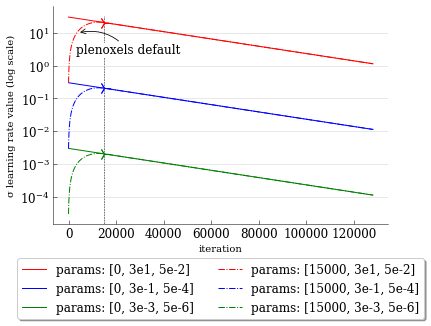

In [142]:
fig, ax = plt.subplots()
fig.set_figheight(5)
iters = 128000
for params in _ALL_SIGMA_LR_SCHEDULERS:
    func = get_expon_lr_func(*params, 1e-2, 250000)
    sigmas = np.zeros(iters)
    xs = np.arange(iters)
    for i in range(iters):
        sigmas[i] = func(i)
    ax.plot(xs, sigmas, label=f'params: [{str(params[0])}, {mapping[str(params[1])]}, {mapping[str(params[2])]}]',
            linewidth=1.0, linestyle=color[str(params[0])], color=color[str(params[1])],
            markevery=[14999], marker='4', markersize=12.0, markerfacecolor=color[str(params[1])], zorder=10)

_, y_max = ax.get_ylim()
plt.plot([14999, 14999], [0, y_max], color='black', linestyle='--', linewidth=0.5, zorder=0)

ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

sns.despine()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=True, ncol=2, prop={'size': 12}, markerscale=0)

ax.annotate('plenoxels default', xy=(4000, 10), xycoords='data', xytext=(3000, 3), textcoords='data',
            size=12.0, va='center', ha='left', bbox=dict(facecolor='white', edgecolor='white', pad=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black', linewidth=0.8))

ax.set_yscale('log')
ax.minorticks_off()
ax.set_xlabel('iteration')
ax.set_ylabel('σ learning rate value (log scale)')
plt.savefig('lr_sigma.pdf', dpi=300, bbox_inches='tight')
plt.show()